In [25]:
!pip3 install numpy matplotlib scipy pandas scikit-learn torch

In [26]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy import optimize as opt
from sklearn import linear_model
from scipy.spatial import procrustes

#  Lorenz Attractor
Next we will attempt to implement our approach above for the Lorenz Attractor descroibed as,

\begin{align*}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy -\beta z
\end{align*}

here we will consider the case that $\sigma = 10, \beta=\frac{8}{3}, \rho=28$, with intial condition $x(0)=0, y(0)=1, z(0)=1.05$.

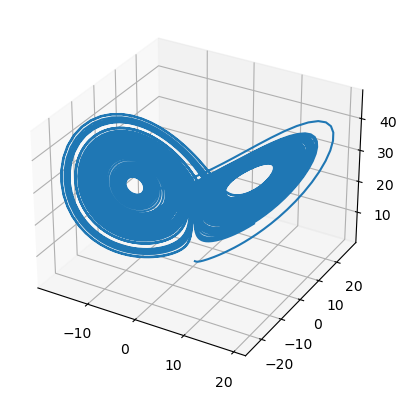

In [27]:
# set the parameters
sigma = 10
beta = 8/3
rho = 28

# define the lorenz attractor
def lorenz_attractor(xyz, t):
    x, y, z = xyz
    dx_dt = sigma*(y-x)
    dy_dt = x*(rho-z) - y
    dz_dt = x*y - beta*z
    return [dx_dt, dy_dt, dz_dt]

# set the initial conditions
initial_conditions = [0, 1, 1.05]

# plot the lorenz attractor
t = np.arange(0, 100, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2])
plt.show()


# Learning Coefficients of the Lorenz Attractor
Suppose that we don't know $\sigma, \beta, \rho$, and we want to learn these coefficients from the data. We can use the same approach as above, but now we will use the data from the Lorenz Attractor to learn the coefficients.

In [28]:
# generate the data
t = np.arange(0, 100, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)

# compute derivatives
dx = sigma*(xyz[:,1]-xyz[:,0])
dy = xyz[:,0]*(rho-xyz[:,2]) - xyz[:,1]
dz = xyz[:,0]*xyz[:,1] - beta*xyz[:,2]

Y = np.array([dx, dy, dz]).T

# solve using Least Squares Regression

# first create library of functions
ones = np.ones(len(t))
x = xyz[:,0]
y = xyz[:,1]
z = xyz[:,2]
x2 = x**2
y2 = y**2
z2 = z**2
xy = x*y
xz = x*z
yz = y*z

# create the library
A = np.array([ones, x, y, z, x2, y2, z2, xy, xz, yz]).T

# solve for the coefficients
clf = linear_model.Lasso(alpha=0.1)
clf.fit(A, Y)
coeff = clf.coef_

print(coeff)

/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e+04, tolerance: 1.726e+03
  model = cd_fast.enet_coordinate_descent(
/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e+04, tolerance: 4.055e+03
  model = cd_fast.enet_coordinate_descent(


[[ 0.00000000e+00 -9.36269124e+00  9.59796617e+00  0.00000000e+00
  -0.00000000e+00 -1.55573582e-04 -4.67494107e-06  2.39475834e-04
  -1.78161227e-02  1.10898811e-02]
 [ 0.00000000e+00  2.73524617e+01 -5.91450197e-01 -0.00000000e+00
   0.00000000e+00  1.64688134e-04  5.09554085e-06 -2.52427966e-04
  -9.81885976e-01 -1.12810939e-02]
 [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.44302648e+00
   3.05216985e-02  5.62919478e-03 -6.56500711e-03  9.72629429e-01
   1.35514363e-05 -4.16259223e-06]]


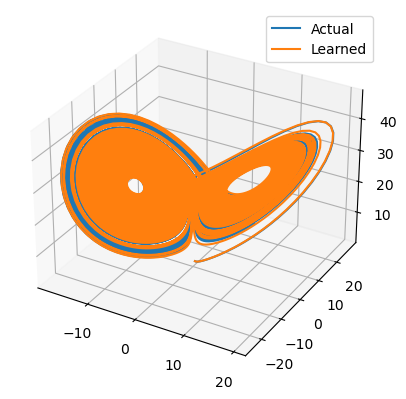

In [29]:
# plot Lorenz Attract using learned coefficients
def lorenz_attractor_learned(xyz, t):
    x, y, z = xyz
    dx_dt = coeff[0,0] + coeff[0,1]*x + coeff[0,2]*y + coeff[0,3]*z + coeff[0,4]*x**2 + coeff[0,5]*y**2 + coeff[0,6]*z**2 + coeff[0,7]*x*y + coeff[0,8]*x*z + coeff[0,9]*y*z
    dy_dt = coeff[1,0] + coeff[1,1]*x + coeff[1,2]*y + coeff[1,3]*z + coeff[1,4]*x**2 + coeff[1,5]*y**2 + coeff[1,6]*z**2 + coeff[1,7]*x*y + coeff[1,8]*x*z + coeff[1,9]*y*z
    dz_dt = coeff[2,0] + coeff[2,1]*x + coeff[2,2]*y + coeff[2,3]*z + coeff[2,4]*x**2 + coeff[2,5]*y**2 + coeff[2,6]*z**2 + coeff[2,7]*x*y + coeff[2,8]*x*z + coeff[2,9]*y*z
    return [dx_dt, dy_dt, dz_dt]

# set the initial conditions
initial_conditions = [0, 1, 1.05]

# plot the learned lorenz attractor and actual Lorenz Attractor
t = np.arange(0, 100, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], label='Actual')
ax.plot(xyz_learned[:,0], xyz_learned[:,1], xyz_learned[:,2], label='Learned')
plt.legend()
plt.show()


In [30]:
# Find Error between learned and actual Lorenz Attractor coefficients
error = np.linalg.norm(xyz-xyz_learned)
print(error)

1935.4465399527808


In [31]:
mtx1, mtx2, disparity = procrustes(xyz, xyz_learned)
round(disparity)

1

# $0 < t < 1$

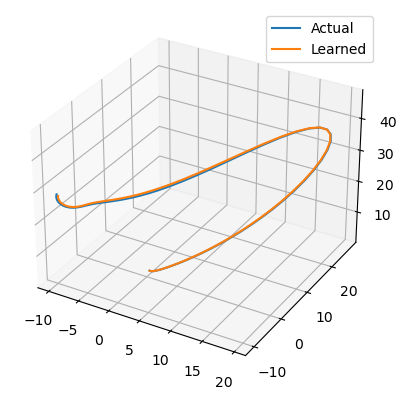

In [32]:

def lorenz_attractor_learned(xyz, t):
    x, y, z = xyz
    dx_dt = coeff[0,0] + coeff[0,1]*x + coeff[0,2]*y + coeff[0,3]*z + coeff[0,4]*x**2 + coeff[0,5]*y**2 + coeff[0,6]*z**2 + coeff[0,7]*x*y + coeff[0,8]*x*z + coeff[0,9]*y*z
    dy_dt = coeff[1,0] + coeff[1,1]*x + coeff[1,2]*y + coeff[1,3]*z + coeff[1,4]*x**2 + coeff[1,5]*y**2 + coeff[1,6]*z**2 + coeff[1,7]*x*y + coeff[1,8]*x*z + coeff[1,9]*y*z
    dz_dt = coeff[2,0] + coeff[2,1]*x + coeff[2,2]*y + coeff[2,3]*z + coeff[2,4]*x**2 + coeff[2,5]*y**2 + coeff[2,6]*z**2 + coeff[2,7]*x*y + coeff[2,8]*x*z + coeff[2,9]*y*z
    return [dx_dt, dy_dt, dz_dt]

# set the initial conditions
initial_conditions = [0, 1, 1.05]

# plot the learned lorenz attractor and actual Lorenz Attractor
t = np.arange(0, 1, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], label='Actual')
ax.plot(xyz_learned[:,0], xyz_learned[:,1], xyz_learned[:,2], label='Learned')
plt.legend()
plt.show()

$1 < t < 5$

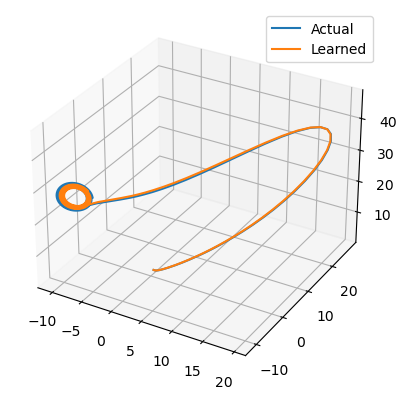

In [33]:
# plot the learned lorenz attractor and actual Lorenz Attractor
t = np.arange(0, 5, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], label='Actual')
ax.plot(xyz_learned[:,0], xyz_learned[:,1], xyz_learned[:,2], label='Learned')
plt.legend()
plt.show()

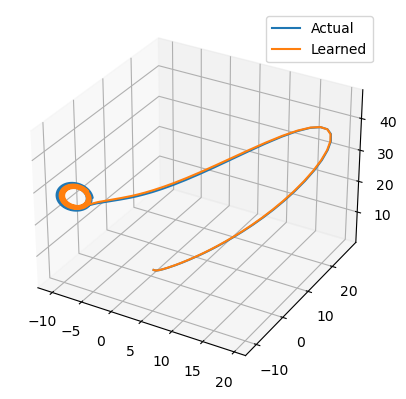

In [34]:
# plot the learned lorenz attractor and actual Lorenz Attractor
t = np.arange(5, 10, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], label='Actual')
ax.plot(xyz_learned[:,0], xyz_learned[:,1], xyz_learned[:,2], label='Learned')
plt.legend()
plt.show()

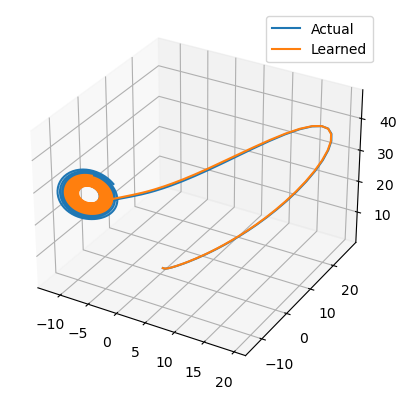

In [35]:
# plot the learned lorenz attractor and actual Lorenz Attractor
t = np.arange(10, 20, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], label='Actual')
ax.plot(xyz_learned[:,0], xyz_learned[:,1], xyz_learned[:,2], label='Learned')
plt.legend()
plt.show()

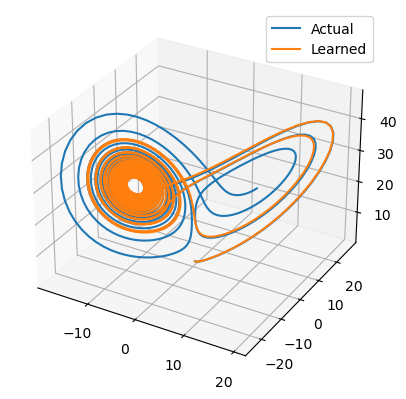

In [36]:
# plot the learned lorenz attractor and actual Lorenz Attractor
t = np.arange(20, 40, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], label='Actual')
ax.plot(xyz_learned[:,0], xyz_learned[:,1], xyz_learned[:,2], label='Learned')
plt.legend()
plt.show()

In [65]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation



t = np.arange(0, 20, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)

def init():
    return lines

def update(num, lines):
    for line, data in zip(lines, [xyz, xyz_learned]):
        line.set_data(data[:num, 0], data[:num, 1])
        line.set_3d_properties(data[:num, 2])
    return lines


# Attaching 3D axis to the figure
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Create lines initially without data
lines = [ax.plot([], [], [])[0] for _ in range(2)]

# Setting the axes properties
ax.set(xlim3d=(-20, 40), xlabel='X')
ax.set(ylim3d=(-20, 40), ylabel='Y')
ax.set(zlim3d=(-20, 40), zlabel='Z')

# Creating the Animation object
ani = animation.FuncAnimation(
    fig, update, len(t), fargs=[lines], init_func=init, blit=True, interval=25, repeat=False)

ani.save('lorenz_attractor.gif', writer='imagemagick', fps=60)

<IPython.core.display.Javascript object>

CalledProcessError: Command '['convert', '-size', '640x480', '-depth', '8', '-delay', '1.6666666666666667', '-loop', '0', 'rgba:-', '-layers', 'OptimizePlus', 'lorenz_attractor.gif']' returned non-zero exit status 2.

#  Lorenz Attractor (reminder)
Next we will attempt to implement our approach above for the Lorenz Attractor descroibed as,

\begin{align*}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy -\beta z
\end{align*}

here we will consider the case that $\sigma = 10, \beta=\frac{8}{3}, \rho=28$, with intial condition $x(0)=0, y(0)=1, z(0)=1.05$.

In [12]:
coeff_exact = np.zeros(coeff.shape)
# order of terms goes..
# 1, x, y, z, x^2, y^2, z^2, xy, xz, yz

# dx/dt
coeff_exact[0, 1] = -sigma
coeff_exact[0, 2] = +sigma
# dy/dt
coeff_exact[1, 1] = rho
coeff_exact[1, 2] = -1
coeff_exact[1, 8] = -1
# dz/dt
coeff_exact[2, 7] = 1
coeff_exact[2, 3] = -beta

[Text(0.5, 1.0, 'Exact coefficient matrix'),
 [Text(0, 0, 'dx/dt'), Text(0, 1, 'dy/dt'), Text(0, 2, 'dz/dt')]]

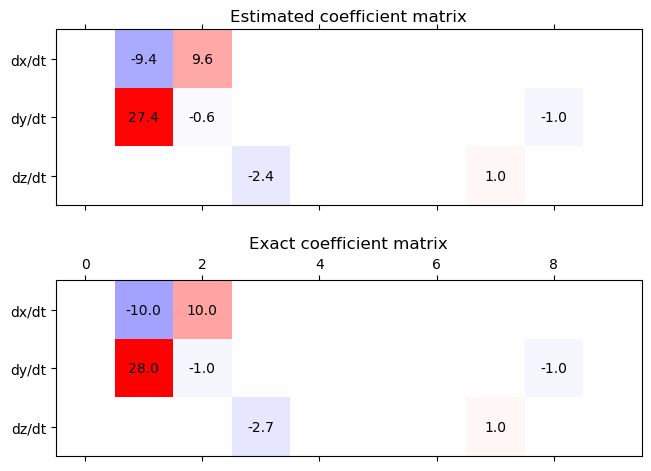

In [13]:
fig,ax = plt.subplots(2,1, sharex=True, sharey=True, constrained_layout=True)

ax[0].matshow(coeff, vmin=-abs(coeff_exact).max(), vmax=abs(coeff_exact).max(), cmap=plt.cm.bwr)
ax[1].matshow(coeff_exact, vmin=-abs(coeff_exact).max(), vmax=abs(coeff_exact).max(), cmap=plt.cm.bwr)

# Conditionally label cell with their values
# modified from https://stackoverflow.com/a/20998634
for (i, j), z in np.ndenumerate(coeff):
    if abs(z) > 1e-1:
        ax[0].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color='k')
for (i, j), z in np.ndenumerate(coeff_exact):
    if abs(z) > 1e-1:
        ax[1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color='k')


ax[0].set(title='Estimated coefficient matrix', yticks=[0,1,2], yticklabels=['dx/dt', 'dy/dt', 'dz/dt'])
ax[1].set(title='Exact coefficient matrix', yticks=[0,1,2], yticklabels=['dx/dt', 'dy/dt', 'dz/dt'])


In [14]:
idx = np.where(abs(coeff - coeff_exact) > 1e-1)
print(coeff[idx])
print(coeff_exact[idx])

[-9.36269124  9.59796617 27.35246165 -0.5914502  -2.44302648]
[-10.          10.          28.          -1.          -2.66666667]


# Error Analysis
## Sampling Rates

/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+03, tolerance: 1.616e+02
  model = cd_fast.enet_coordinate_descent(
/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e+03, tolerance: 3.866e+02
  model = cd_fast.enet_coordinate_descent(
/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

[[ 0.00000000e+00 -8.76384479e+00  9.15655695e+00  2.98088781e-02
   3.42068992e-02  8.70110675e-03 -2.22538197e-03 -3.41138510e-02
  -3.69673043e-02  2.56815971e-02]
 [ 0.00000000e+00  2.70044121e+01 -3.17139814e-01 -1.15498904e-02
  -2.62528453e-02 -7.09317323e-03  1.43336827e-03  2.67492848e-02
  -9.70214897e-01 -2.08196937e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.42579884e+00
   5.61484650e-02  1.50967567e-02 -8.23689500e-03  9.42929948e-01
  -7.27468415e-04  4.23853818e-04]]
[[  0.         -10.          10.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          28.          -1.           0.           0.
    0.           0.           0.          -1.           0.        ]
 [  0.           0.           0.          -2.66666667   0.
    0.           0.           1.           0.           0.        ]]


/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e+02, tolerance: 1.991e+01
  model = cd_fast.enet_coordinate_descent(
/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e+02, tolerance: 4.862e+01
  model = cd_fast.enet_coordinate_descent(
/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

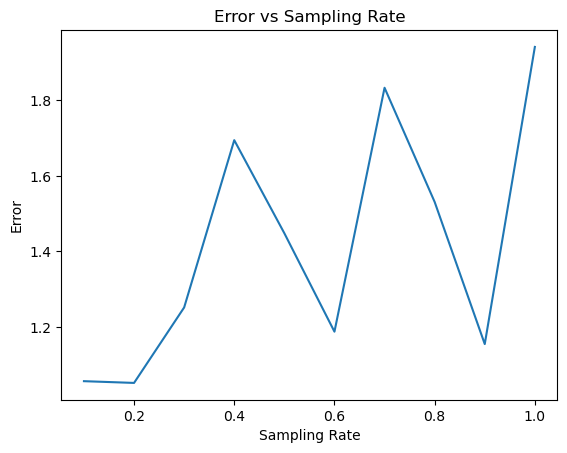

In [19]:
# Experiment for sample size 
sampling_rates = np.linspace(0.1, 1, 10)
errors = []

for rate in sampling_rates:
    # generate the data
    t = np.arange(0, 100, rate)
    xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
    
    # compute derivatives
    dx = sigma*(xyz[:,1]-xyz[:,0])
    dy = xyz[:,0]*(rho-xyz[:,2]) - xyz[:,1]
    dz = xyz[:,0]*xyz[:,1] - beta*xyz[:,2]
    
    Y = np.array([dx, dy, dz]).T
    
    # solve using Least Squares Regression
    
    # first create library of functions
    ones = np.ones(len(t))
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    x2 = x**2
    y2 = y**2
    z2 = z**2
    xy = x*y
    xz = x*z
    yz = y*z
    
    # create the library
    A = np.array([ones, x, y, z, x2, y2, z2, xy, xz, yz]).T
    
    # solve for the coefficients
    clf = linear_model.Lasso(alpha=0.1)
    clf.fit(A, Y)
    coeff = clf.coef_
    
    # compute coefficient errors
    error = np.linalg.norm(coeff - coeff_exact)
    errors.append(error)


plt.plot(sampling_rates, errors)
plt.xlabel('Sampling Rate')
plt.ylabel('Error')
plt.title('Error vs Sampling Rate')
plt.show()

## Noise

/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e+04, tolerance: 1.726e+03
  model = cd_fast.enet_coordinate_descent(
/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e+04, tolerance: 4.055e+03
  model = cd_fast.enet_coordinate_descent(
/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

[[ 0.00000000e+00 -9.68704407e+00  9.79573849e+00  0.00000000e+00
  -0.00000000e+00 -5.19441097e-07  1.28699534e-06  0.00000000e+00
  -8.97763290e-03  5.92800593e-03]
 [ 0.00000000e+00  2.77067127e+01 -8.07253397e-01 -0.00000000e+00
   0.00000000e+00  2.35649467e-07 -1.03837596e-06 -0.00000000e+00
  -9.91575259e-01 -5.61404778e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.59627880e+00
   6.18486653e-03  2.13332436e-03 -1.76096274e-03  9.93034076e-01
   7.52194380e-06  1.65573363e-07]]


/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.320e+03, tolerance: 4.209e+03
  model = cd_fast.enet_coordinate_descent(


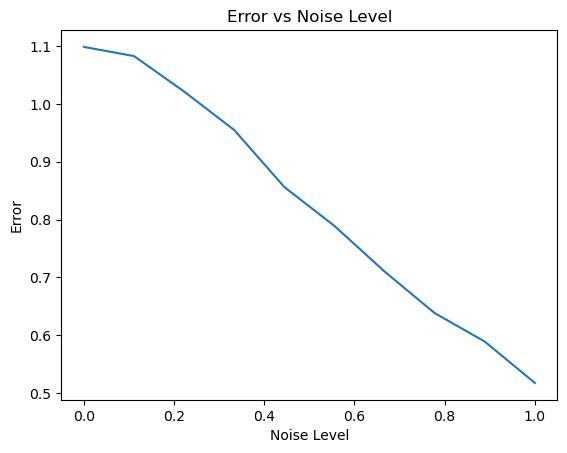

In [17]:
# Experiment for noise
noises = np.linspace(0, 1, 10)
errors = []

for noise in noises:
    # generate the data
    t = np.arange(0, 100, 0.01)
    xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
    
    # add noise
    xyz = xyz + noise*np.random.randn(*xyz.shape)
    
    # compute derivatives
    dx = sigma*(xyz[:,1]-xyz[:,0])
    dy = xyz[:,0]*(rho-xyz[:,2]) - xyz[:,1]
    dz = xyz[:,0]*xyz[:,1] - beta*xyz[:,2]
    
    Y = np.array([dx, dy, dz]).T
    
    # solve using Least Squares Regression
    
    # first create library of functions
    ones = np.ones(len(t))
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    x2 = x**2
    y2 = y**2
    z2 = z**2
    xy = x*y
    xz = x*z
    yz = y*z
    
    # create the library
    A = np.array([ones, x, y, z, x2, y2, z2, xy, xz, yz]).T
    
    # solve for the coefficients
    clf = linear_model.Lasso(alpha=0.1)
    clf.fit(A, Y)
    coeff = clf.coef_
    
    # compute coefficient errors
    error = np.linalg.norm(coeff - coeff_exact)
    errors.append(error)


plt.plot(noises, errors)
plt.xlabel('Noise Level')
plt.ylabel('Error')
plt.title('Error vs Noise Level') 
plt.show()

## Varying $\alpha$ in Lasso

/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e+04, tolerance: 1.726e+03
  model = cd_fast.enet_coordinate_descent(
/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e+04, tolerance: 4.055e+03
  model = cd_fast.enet_coordinate_descent(
/Users/nreef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

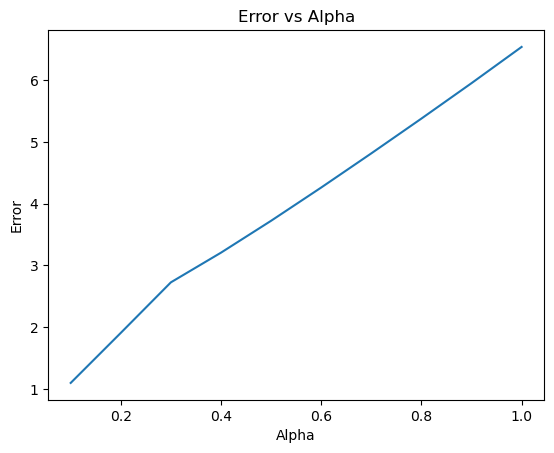

In [18]:
# Experiment for varying alpha in Lasso
alphas = np.linspace(0.1, 1, 10)
errors = []

for alpha in alphas:
    # generate the data
    t = np.arange(0, 100, 0.01)
    xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
    
    # compute derivatives
    dx = sigma*(xyz[:,1]-xyz[:,0])
    dy = xyz[:,0]*(rho-xyz[:,2]) - xyz[:,1]
    dz = xyz[:,0]*xyz[:,1] - beta*xyz[:,2]
    
    Y = np.array([dx, dy, dz]).T
    
    # solve using Least Squares Regression
    
    # first create library of functions
    ones = np.ones(len(t))
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    x2 = x**2
    y2 = y**2
    z2 = z**2
    xy = x*y
    xz = x*z
    yz = y*z
    
    # create the library
    A = np.array([ones, x, y, z, x2, y2, z2, xy, xz, yz]).T
    
    # solve for the coefficients
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(A, Y)
    coeff = clf.coef_
    
    # compute coefficient errors
    error = np.linalg.norm(coeff - coeff_exact)
    errors.append(error)

plt.plot(alphas, errors)
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.title('Error vs Alpha')
plt.show()

# Utilizing know coefficient placements